In [1]:
import random
import typing as tp
import csv
import pickle
import re
from collections import Counter

import numpy as np
import keras
import keras.layers
import keras.optimizers
import keras.callbacks
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
MODEL_NAME = "StructureModelPOL"
POL = True if MODEL_NAME.endswith('POL') else False

TO_EXCLUDE = '!"#$%&()*+-—/:;<=>@[\\]^_`{|}~.,:;!?\t«»'
TO_TOKENIZE = '\n'

In [3]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file, encoding='UTF-8') as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

if POL:
    TEXT = load_data('data/poems/pl/kochanowski.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/slowacki.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/tacohemingway.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/ostr.csv', TO_TOKENIZE, TO_EXCLUDE)
else:
    TEXT = load_data('data/poems/eng/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 4000)

print(*TEXT[:3])

100%|██████████| 40/40 [00:00<00:00, 2800.96it/s]

tobie bądź chwała panie wszego świata 
 żeś nam doczekać dał nowego lata 
 daj byśmy się i sami odnowili 
 grzech porzuciwszy  w niewinności żyli 
 łaska twa święta niechaj będzie z nami 
 bo nic dobrego nie uczynim sami 
 mnóż w nas nadzieję przyspórz prawej wiary 
 niech uważamy twe prawdziwe dary 
 użycz pokoju nam i świętej zgody 
 niech się nas boją pogańskie narody 
 a ty nas nie chciej odstępować panie 
 i owszem racz nam dopomagać na nie 
 błogosław ziemi z twej szczodrobliwości 
 niechaj nam dawa dostatek żywności 
 uchowaj głodu i powietrza złego 
 daj wszystko dobre z miłosierdzia swego 
  prózno uciec prózno się przed miłością schronić 
 bo jako lotny nie ma pieszego dogonić 
  kupić by cię mądrości za drogie pieniądze 
 która jesli prawdziwie mienią wszytki żądze 
 wszytki ludzkie frasunki umiesz wykorzenić 
 a człowieka tylko nie w anioła odmienić 
 który nie wie co boleść frasunku nie czuje 
 złym przygodom nie podległ strachom nie hołduje 
 ty wszytki rzeczy ludzkie mas

In [4]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE, num_words=6000)
TOKENIZER.fit_on_texts(TEXT)
WORD_COUNTER = Counter(' '.join(TEXT).split(' '))
TOTAL_WORDS = TOKENIZER.num_words or len(TOKENIZER.word_index) + 1

print(f"Total number of words: {TOTAL_WORDS}")
print(f"Number of words occurrence: {sorted(dict(WORD_COUNTER).items(), key=lambda x: x[1], reverse=True)[:20]}")

Total number of words: 6000
Number of words occurrence: [('\n', 29307), ('i', 4728), ('w', 4604), ('nie', 4133), ('na', 3283), ('', 2908), ('się', 2876), ('a', 2599), ('z', 2464), ('to', 1914), ('jak', 1761), ('co', 1183), ('że', 1149), ('o', 989), ('do', 967), ('tak', 966), ('jest', 842), ('za', 812), ('mi', 792), ('mnie', 778)]


In [5]:
def create_sequences(text, tokenizer, max_len: int = 10):
    sequences = list()
    for verse in tqdm(text):
        encoded = tokenizer.texts_to_sequences([verse])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[max(i + 1 - max_len, 0):i + 1]
            sequences.append(sequence)
    return sequences

SEQUENCES = create_sequences(TEXT, TOKENIZER)
print(f"Total Sequences: {len(SEQUENCES)}")

100%|██████████| 897/897 [00:00<00:00, 1911.58it/s]

Total Sequences: 171633


In [6]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_WORDS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 10


In [7]:
def create_model(total_words: int, sequence_length: int):
    # define model
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_words, 256, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(total_words, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
MODEL = keras.models.load_model(MODEL_PATH)
# MODEL = create_model(TOTAL_WORDS, SEQUENCE_LENGTH)
print(MODEL.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 256)            1536000   
                                                                 
 lstm (LSTM)                 (None, 9, 256)            525312    
                                                                 
 dropout (Dropout)           (None, 9, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6000)              774000    
                                                                 
Total params: 3,032,432
Trainable params: 3,032,432
Non-

In [8]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_verse(model: keras.Model, tokenizer: Tokenizer, in_text: str, max_words: int = 60):
    for _ in range(max_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=model.input_shape[-1], padding='pre')
        predicted = np.argmax(model.predict(encoded, verbose=0))
        out_word = REVERSE_TOKEN_INDEX.get(predicted, None)
        in_text += ' ' + out_word
        if in_text.count('\n') == 4:
            break
    return in_text


In [9]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 2
            if epoch % frequency == 0:
                seq = generate_verse(MODEL, TOKENIZER, "A drzewo", 20)
                print(f"\n{seq}")
                print(f"{TOKENIZER.texts_to_sequences([seq])[0]}")

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=5))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True
    ))
    return callbacks


In [18]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=40,
    validation_split=0.1,
    verbose=1,
    batch_size=128,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/20
1207/1207 [==============================] - ETA: 0s - loss: 1.3351 - accuracy: 0.6570
A drzewo tym by jest że dnia duchy duchów z tobą 
 od 
 który duch 
 będą pięknie 

[7, 1136, 33, 38, 16, 12, 695, 381, 467, 8, 209, 1, 35, 1, 59, 150, 1, 141, 1985, 1]
1207/1207 [==============================] - 196s 162ms/step - loss: 1.3351 - accuracy: 0.6570 - val_loss: 21.9463 - val_accuracy: 0.0908
Epoch 2/20
1207/1207 [==============================] - 160s 132ms/step - loss: 1.3131 - accuracy: 0.6621 - val_loss: 21.6522 - val_accuracy: 0.0898
Epoch 3/20
1207/1207 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.6634
A drzewo tym grobie jest fontanna 
 na czoło bracia ciemne 
 dla których mi koń 
 i chleb wszystko jak z
[7, 1136, 33, 365, 16, 3164, 1, 5, 696, 823, 1028, 1, 53, 236, 18, 527, 1, 2, 1375, 80, 10, 8]
1207/1207 [==============================] - 161s 133ms/step - loss: 1.3085 - accuracy: 0.6634 - val_loss: 22.1754 - val_accuracy: 0.0893
Epoch 4/20

In [19]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", "wb") as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"data/models/{MODEL_NAME}/history.pickle", "wb") as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

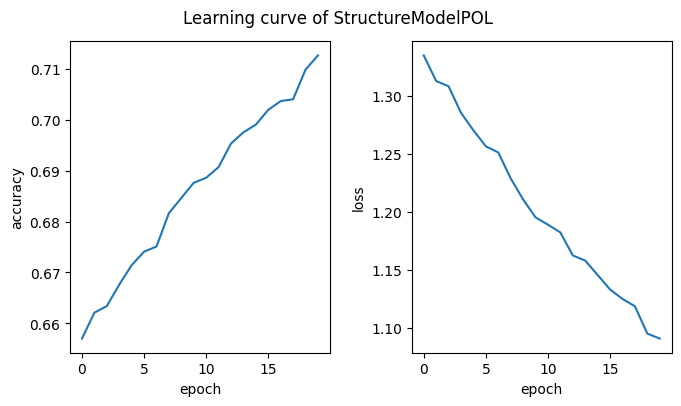

In [20]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f"Learning curve of {MODEL_NAME}")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [21]:
print(generate_verse(MODEL, TOKENIZER, ""))

 krótkie rzeczy miła 
 się na boga 
 bo tak widzisz i w końcu drogi 
 gdzież ja nigdy jest bez i przez wieki 



In [22]:
def similarity(a: tp.List[tp.List[int]], b: tp.List[int]):
    return np.dot(a, b)/(np.linalg.norm(a, axis=1) * np.linalg.norm(b))

def measure_structure_similarity(model: keras.Model, tokenizer: Tokenizer, text: str, tests: int = 20):
    a = [[len(line) for line in verse.split('\n')[:4]] for verse in text if len(verse.split('\n')) >= 4]
    words = list(TOKENIZER.word_index.keys())
    result = []
    for _ in tqdm(range(tests)):
        verse = generate_verse(model, tokenizer, random.choice(words))
        b = [len(line) for line in verse.split('\n')[:4]]
        sim = similarity(a, b)
        result.append(np.mean(sim))
    return np.mean(result)

MEAN_SIMILARITY = measure_structure_similarity(MODEL, TOKENIZER, TEXT)
print(f"Mean cousine similarity: {MEAN_SIMILARITY}")

100%|██████████| 20/20 [00:36<00:00,  1.84s/it]

Mean cousine similarity: 0.9351700696662913
